In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from imagePreProcessor import *
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf
import datefinder
import dateparser
from IPython.display import clear_output

importing Jupyter notebook from imagePreProcessor.ipynb


2023-06-21 15:35:07.148236: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2'

In [3]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset/')

In [4]:
df = pd.read_csv("tesseract.csv")

In [5]:
df.shape

(185, 30)

In [6]:
df.drop_duplicates(subset=["x", "y", "imageName"], keep="first", inplace=True)

In [7]:
df.shape

(124, 30)

In [8]:
df.describe()

,Unnamed: 0,block_num,line_num,left,top,width,height,conf,x,y,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,92.064516,9.290323,1.790323,1238.338710,1168.266129,229.693548,33.653226,84.391958,1468.032258,1201.919355,...,557.646630,147.633633,102.024125,115.157891,177.328995,680.921835,428.680619,20.364179,14.815863,0.419355
std,53.897183,8.595493,3.527532,736.752067,838.168349,184.025678,7.411312,16.716716,708.793696,838.845806,...,606.224805,523.030673,390.963097,306.608087,468.005785,801.055870,786.865160,110.618704,75.168796,0.495455
min,0.000000,1.000000,0.000000,73.000000,67.000000,72.000000,18.000000,0.000000,210.000000,97.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.500000,4.000000,0.000000,560.500000,574.750000,166.250000,29.000000,79.415279,839.750000,616.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.000000,6.500000,1.000000,1150.500000,843.000000,189.000000,32.500000,90.290752,1408.000000,872.500000,...,389.698446,0.000000,0.000000,0.000000,0.000000,458.453030,0.000000,0.000000,0.000000,0.000000
75%,137.250000,11.000000,2.000000,1891.250000,1554.000000,224.500000,37.250000,96.286427,2113.000000,1584.000000,...,724.088892,0.000000,0.000000,0.000000,0.000000,1050.048512,448.026705,0.000000,0.000000,1.000000
max,183.000000,46.000000,26.000000,3319.000000,3925.000000,1696.000000,71.000000,96.915260,3391.000000,3961.000000,...,2614.345999,3199.536529,2622.190306,2127.643062,3019.951324,3654.836795,3672.623722,892.261173,500.144979,1.000000


In [9]:
len(df["imageName"].unique())

51

In [10]:
df.head()

,Unnamed: 0,block_num,line_num,left,top,width,height,conf,text,x,...,delivery,order,due,payment,tax,bill,receipt,issue,imageName,output
0,0,6,2,1834,743,188,32,96.690132,12.01.2023,2022,...,0.0,0.0,0.0,0.0,454.001101,0.0,0.000000,0.0,68.jpeg,1
2,2,27,1,2229,2351,155,25,95.671471,28-03-2023:,2384,...,0.0,0.0,0.0,0.0,0.000000,0.0,288.006944,0.0,55.jpeg,0
3,3,8,0,1806,287,249,28,73.119611,"Mar 28, 2023 16:37 to",2055,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,55.jpeg,0
4,4,8,0,1806,473,153,32,80.006772,"‘Mar 28, 2023",1959,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,55.jpeg,0
5,5,11,0,73,725,1045,33,86.849951,"Third Party Policy No. - D055998378, valid fro...",1118,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,55.jpeg,0


In [11]:
def preProcess(df):
    for index in df.index:
        
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        X = X/2
        Y = df["PageHeight"][index]
        Y = Y/2
        
        if x<X:
            df["isLeft"][index]=1
        elif x>=X:
            df["isRight"][index]=1
            
        if y>Y:
            df["isBottom"][index]=1
        elif y<Y:
            df["isTop"][index]=1
            
        
            
    df["x"]/=df["PageWidth"]
    df["y"]/=df["PageHeight"]

    df["conf"]/=100

    neighbourFields = ["date", "dated", "invoice", "delivery", "order", "due", "payment", "tax", "bill", "receipt", "issue"]

    for col in neighbourFields:
        df[col]/=4000
    
    colsToDrop = ["Unnamed: 0", "left", "top", "width", "height", "imageName", "text", "PageHeight", "PageWidth"]
    df.drop(columns=colsToDrop, inplace=True)
    

In [12]:
preProcess(df)

/tmp/ipykernel_16395/3378690190.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_16395/3378690190.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isTop"][index]=1
/tmp/ipykernel_16395/3378690190.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isBottom"][index]=1
/tmp/ipykernel_16395/3378690190.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [13]:
df

,block_num,line_num,conf,x,y,isTop,isBottom,isRight,isLeft,date,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
0,6,2,0.966901,0.815651,0.220924,1,0,1,0,0.000000,...,0.077500,0.0,0.0,0.000000,0.000000,0.113500,0.000000,0.000000,0.0,1
2,27,1,0.956715,0.961678,0.678857,0,1,1,0,0.054005,...,0.479420,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.072002,0.0,0
3,8,0,0.731196,0.828963,0.090000,1,0,1,0,0.000000,...,0.155250,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
4,8,0,0.800068,0.790238,0.144286,1,0,1,0,0.000000,...,0.112286,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
5,11,0,0.868500,0.450988,0.216571,1,0,0,1,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,6,2,0.540741,0.824314,0.238000,1,0,1,0,0.125190,...,0.150404,0.0,0.0,0.165576,0.000000,0.203135,0.000000,0.000000,0.0,0
180,11,1,0.667299,0.467451,0.528000,0,1,0,1,0.258487,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
181,11,1,0.968660,0.449194,0.199770,1,0,0,1,0.091311,...,0.174018,0.0,0.0,0.000000,0.203500,0.217007,0.000000,0.000000,0.0,0
182,11,2,0.961782,0.445565,0.200918,1,0,0,1,0.093750,...,0.172417,0.0,0.0,0.000000,0.201252,0.215240,0.000000,0.000000,0.0,0


In [14]:
df.describe()

,block_num,line_num,conf,x,y,isTop,isBottom,isRight,isLeft,date,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,9.290323,1.790323,0.843920,0.552995,0.342699,0.766129,0.233871,0.516129,0.483871,0.087487,...,0.139412,0.036908,0.025506,0.028789,0.044332,0.170230,0.107170,0.005091,0.003704,0.419355
std,8.595493,3.527532,0.167167,0.256095,0.227847,0.425008,0.425008,0.501767,0.501767,0.164085,...,0.151556,0.130758,0.097741,0.076652,0.117001,0.200264,0.196716,0.027655,0.018792,0.495455
min,1.000000,0.000000,0.000000,0.059795,0.019529,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.794153,0.336765,0.171042,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.500000,1.000000,0.902908,0.507865,0.254242,1.000000,0.000000,1.000000,0.000000,0.036298,...,0.097425,0.000000,0.000000,0.000000,0.000000,0.114613,0.000000,0.000000,0.000000,0.000000
75%,11.000000,2.000000,0.962864,0.816156,0.473366,1.000000,0.000000,1.000000,1.000000,0.101672,...,0.181022,0.000000,0.000000,0.000000,0.000000,0.262512,0.112007,0.000000,0.000000,1.000000
max,46.000000,26.000000,0.969153,0.961678,0.978286,1.000000,1.000000,1.000000,1.000000,0.986337,...,0.653586,0.799884,0.655548,0.531911,0.754988,0.913709,0.918156,0.223065,0.125036,1.000000


In [15]:
df.isna().sum().sum()

0

In [16]:
df.corr()

,block_num,line_num,conf,x,y,isTop,isBottom,isRight,isLeft,date,...,invoice,delivery,order,due,payment,tax,bill,receipt,issue,output
block_num,1.000000,-0.051603,-0.041894,-0.006286,0.082589,-0.034675,0.034675,-0.031255,0.031255,-0.044741,...,-0.129523,-0.045052,-0.087421,-0.061252,-0.062186,-0.105085,0.102772,0.277052,-0.021883,0.013179
line_num,-0.051603,1.000000,0.101685,-0.062768,0.176291,-0.087203,0.087203,-0.039413,0.039413,-0.010646,...,0.061793,0.003979,-0.002577,0.145707,0.069881,0.040951,0.056954,-0.029748,0.024584,-0.181870
conf,-0.041894,0.101685,1.000000,0.029898,0.038069,-0.012711,0.012711,-0.017299,0.017299,-0.127099,...,0.076392,0.001028,0.062198,-0.131895,0.015979,0.066162,0.165123,0.130927,0.134001,0.103813
x,-0.006286,-0.062768,0.029898,1.000000,-0.070441,0.062561,-0.062561,0.895288,-0.895288,0.168034,...,0.332221,0.151611,0.179596,0.086542,0.121839,0.220309,0.206353,0.227448,-0.249344,0.184620
y,0.082589,0.176291,0.038069,-0.070441,1.000000,-0.864841,0.864841,-0.031135,0.031135,0.291836,...,0.387889,0.353126,0.257090,0.210055,0.353806,0.503863,0.247782,-0.075686,-0.169840,-0.443466
isTop,-0.034675,-0.087203,-0.012711,0.062561,-0.864841,1.000000,-1.000000,0.036894,-0.036894,-0.405417,...,-0.406504,-0.396898,-0.241157,-0.231407,-0.436236,-0.433326,-0.305311,0.052321,0.109341,0.315102
isBottom,0.034675,0.087203,0.012711,-0.062561,0.864841,-1.000000,1.000000,-0.036894,0.036894,0.405417,...,0.406504,0.396898,0.241157,0.231407,0.436236,0.433326,0.305311,-0.052321,-0.109341,-0.315102
isRight,-0.031255,-0.039413,-0.017299,0.895288,-0.031135,0.036894,-0.036894,1.000000,-1.000000,0.225406,...,0.294629,0.228697,0.215727,0.018480,0.097921,0.243837,0.192921,0.178971,-0.204391,0.168790
isLeft,0.031255,0.039413,0.017299,-0.895288,0.031135,-0.036894,0.036894,-1.000000,1.000000,-0.225406,...,-0.294629,-0.228697,-0.215727,-0.018480,-0.097921,-0.243837,-0.192921,-0.178971,0.204391,-0.168790
date,-0.044741,-0.010646,-0.127099,0.168034,0.291836,-0.405417,0.405417,0.225406,-0.225406,1.000000,...,0.411886,0.684137,0.023548,0.116499,0.630323,0.547880,0.537127,-0.076164,-0.010907,-0.208841


In [17]:
df.drop(columns=["block_num", "delivery", "order", "issue", "conf"], inplace=True)

In [18]:
df.shape

(124, 16)

In [19]:
len(df[df["output"]==0])

72

In [20]:
len(df[df["output"]==1])

52

In [21]:
# dfTrue = df[df["output"]==1].sample(frac=1)[:52]
# dfFalse = df[df["output"]==0].sample(frac=1)[:52]
# df = pd.concat([dfTrue, dfFalse], axis=0).sample(frac=1)
# df


In [22]:
df.corr()

,line_num,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,due,payment,tax,bill,receipt,output
line_num,1.000000,-0.062768,0.176291,-0.087203,0.087203,-0.039413,0.039413,-0.010646,-0.018494,0.061793,0.145707,0.069881,0.040951,0.056954,-0.029748,-0.181870
x,-0.062768,1.000000,-0.070441,0.062561,-0.062561,0.895288,-0.895288,0.168034,0.128912,0.332221,0.086542,0.121839,0.220309,0.206353,0.227448,0.184620
y,0.176291,-0.070441,1.000000,-0.864841,0.864841,-0.031135,0.031135,0.291836,0.308333,0.387889,0.210055,0.353806,0.503863,0.247782,-0.075686,-0.443466
isTop,-0.087203,0.062561,-0.864841,1.000000,-1.000000,0.036894,-0.036894,-0.405417,-0.365832,-0.406504,-0.231407,-0.436236,-0.433326,-0.305311,0.052321,0.315102
isBottom,0.087203,-0.062561,0.864841,-1.000000,1.000000,-0.036894,0.036894,0.405417,0.365832,0.406504,0.231407,0.436236,0.433326,0.305311,-0.052321,-0.315102
isRight,-0.039413,0.895288,-0.031135,0.036894,-0.036894,1.000000,-1.000000,0.225406,0.210032,0.294629,0.018480,0.097921,0.243837,0.192921,0.178971,0.168790
isLeft,0.039413,-0.895288,0.031135,-0.036894,0.036894,-1.000000,1.000000,-0.225406,-0.210032,-0.294629,-0.018480,-0.097921,-0.243837,-0.192921,-0.178971,-0.168790
date,-0.010646,0.168034,0.291836,-0.405417,0.405417,0.225406,-0.225406,1.000000,0.838006,0.411886,0.116499,0.630323,0.547880,0.537127,-0.076164,-0.208841
dated,-0.018494,0.128912,0.308333,-0.365832,0.365832,0.210032,-0.210032,0.838006,1.000000,0.353803,-0.068479,0.618449,0.607618,0.606930,-0.051311,-0.192221
invoice,0.061793,0.332221,0.387889,-0.406504,0.406504,0.294629,-0.294629,0.411886,0.353803,1.000000,0.386059,0.411691,0.686432,0.431696,-0.076069,-0.170987


In [23]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [24]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [25]:
len(yTest[yTest==1])

10

In [26]:
xTrain.shape

(99, 15)

In [27]:
xTest.shape

(25, 15)

In [28]:
yTrain.shape

(99,)

In [29]:
yTest.shape

(25,)

In [51]:
def getModel():
    model = keras.Sequential([
    keras.layers.Dense(16,  input_shape=(15, ), activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
    ])

    model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["accuracy", 'Precision', "Recall", "TruePositives", "TrueNegatives", "FalsePositives", "FalseNegatives"])
    
    return model

In [52]:
model = getModel()

In [53]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                256       
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(xTrain, yTrain, epochs=200, batch_size=1)

Epoch 1/200


99/99 [==============================] - 1s 1ms/step - loss: 0.6699 - accuracy: 0.5556 - precision: 0.4828 - recall: 0.6667 - true_positives: 28.0000 - true_negatives: 27.0000 - false_positives: 30.0000 - false_negatives: 14.0000    
Epoch 2/200
99/99 [==============================] - 0s 1ms/step - loss: 0.6425 - accuracy: 0.6263 - precision: 0.5714 - recall: 0.4762 - true_positives: 20.0000 - true_negatives: 42.0000 - false_positives: 15.0000 - false_negatives: 22.0000  
Epoch 3/200
99/99 [==============================] - 0s 1ms/step - loss: 0.6259 - accuracy: 0.6364 - precision: 0.5882 - recall: 0.4762 - true_positives: 20.0000 - true_negatives: 43.0000 - false_positives: 14.0000 - false_negatives: 22.0000 
Epoch 4/200
99/99 [==============================] - 0s 1ms/step - loss: 0.6089 - accuracy: 0.6263 - precision: 0.5676 - recall: 0.5000 - true_positives: 21.0000 - true_negatives: 41.0000 - false_positives: 16.0000 - false_negatives: 21.0000             
Epoch 5/200
99/99 [=====

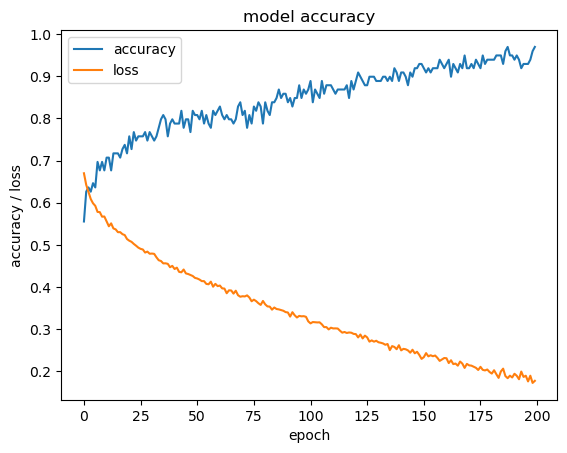

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.legend(["accuracy", "loss"])
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.show()

In [62]:
model.evaluate(xTest, yTest)

1/1 [==============================] - ETA: 0s - loss: 0.9505 - accuracy: 0.8800 - precision: 0.8182 - recall: 0.9000 - true_positives: 9.0000 - true_negatives: 13.0000 - false_positives: 2.0000 - false_negatives: 1.0000

1/1 [==============================] - 0s 26ms/step - loss: 0.9505 - accuracy: 0.8800 - precision: 0.8182 - recall: 0.9000 - true_positives: 9.0000 - true_negatives: 13.0000 - false_positives: 2.0000 - false_negatives: 1.0000


[0.9505415558815002,
 0.8799999952316284,
 0.8181818127632141,
 0.8999999761581421,
 9.0,
 13.0,
 2.0,
 1.0]

In [57]:
from sklearn.model_selection import KFold

In [58]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

In [59]:
i=0
scores = []
for train_index, test_index in list(KFold(n_splits=3).split(X,Y)):
    i+=1
    print("Fold ", str(i))
    x_train,x_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test=Y.iloc[train_index],Y.iloc[test_index]
   
    model=getModel()

    model.fit(x_train, y_train,epochs=300, batch_size=1, verbose=2)
    clear_output(wait=True)

    results = model.evaluate(x_test, y_test)

    scores.append(results)


2/2 [==============================] - 0s 6ms/step - loss: 1.3945 - accuracy: 0.6341 - precision: 0.5000 - recall: 0.6667 - true_positives: 10.0000 - true_negatives: 16.0000 - false_positives: 10.0000 - false_negatives: 5.0000


In [60]:
acc = [score[1] for score in scores]
print(sum(acc)/len(acc))

0.6614401737848917
